In [1]:
from pathlib import Path
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

sys.path.append("..")

from util_image import (
    get_annotation_from_mask,
    get_annotation_from_mask_file,
    get_mask_file,
    invert_mask,
    pil_to_array_1c,
    pil_to_array_3c,
)

In [2]:
data_dir = Path.cwd().parent / "hawking_data_dir"
bg_dir = data_dir / "backgrounds"
obj_dir = data_dir / "objects_dir" / "cart"
dis_dir = data_dir / "distractor_objects_dir" / "hemp_sack"

bg_path = list(bg_dir.glob("*.png"))[0]
obj_path = list(obj_dir.glob("*.jpg"))[10]
dis_path = list(dis_dir.glob("*.jpg"))[0]

In [3]:
obj_mask_file = get_mask_file(obj_path)
o_xmin, o_xmax, o_ymin, o_ymax = get_annotation_from_mask_file(
    obj_mask_file, True
)

dis_mask_file = get_mask_file(dis_path)
d_xmin, d_xmax, d_ymin, d_ymax = get_annotation_from_mask_file(
    dis_mask_file, True
)

In [4]:
w = 1024
h = 768
bg = Image.open(bg_path)
bg = bg.resize((w, h), Image.ANTIALIAS)

obj_fg = Image.open(obj_path)
obj_mask = invert_mask(Image.open(obj_mask_file))

dis_fg = Image.open(dis_path)
dis_mask = invert_mask(Image.open(dis_mask_file))

### Preview images

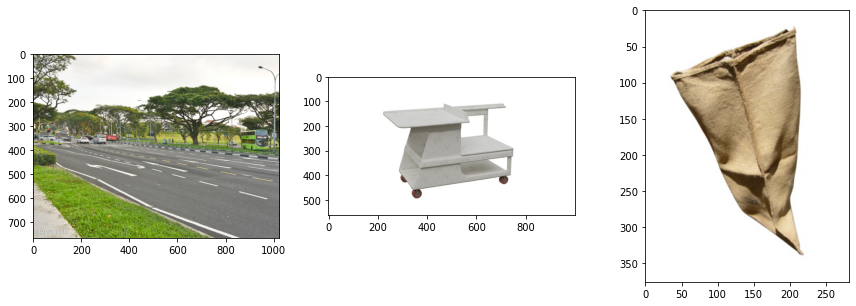

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bg)
ax[1].imshow(obj_fg)
ax[2].imshow(dis_fg)

In [6]:
o_xmin, o_xmax, o_ymin, o_ymax = get_annotation_from_mask_file(
    obj_mask_file, True
)
orig_w, orig_h = o_xmax - o_xmin, o_ymax - o_ymin

### Expand object size (local distractor)

In [7]:
obj_fg_copy = obj_fg.copy()
obj_mask_copy = obj_mask.copy()

obj_fg_size = obj_fg.size
# row, col
coords = [(0.65, 0.5), (0.25, 0.5), (0.5, 0.95)]
for coord in coords:
    dis_fg_copy = dis_fg.copy()
    dis_mask_copy = dis_mask.copy()
    d_xmin, d_xmax, d_ymin, d_ymax = get_annotation_from_mask_file(
        dis_mask_file, True
    )
    dis_fg_copy = dis_fg_copy.crop((d_xmin, d_ymin, d_xmax, d_ymax))
    dis_mask_copy = dis_mask_copy.crop((d_xmin, d_ymin, d_xmax, d_ymax))

    rot_deg = 30
    dis_fg_copy = dis_fg_copy.rotate(rot_deg, expand=True)
    dis_mask_copy = dis_mask_copy.rotate(rot_deg, expand=True)
    o_w, o_h = dis_fg_copy.size
    x = int(obj_fg_size[0] * coord[1] - o_w / 2 + 1)
    y = int(obj_fg_size[1] * coord[0] - o_h / 2 + 1)
    pad = -min(x, obj_fg_size[0] - x - o_w, y, obj_fg_size[1] - y - o_h)
    if pad > 0:
        dst_size = (obj_fg_size[0] + 2 * pad, obj_fg_size[1] + 2 * pad)
        obj_fg_copy = ImageOps.pad(obj_fg_copy, dst_size)
        obj_mask_copy = ImageOps.pad(obj_mask_copy, dst_size)
        x += pad
        y += pad
    obj_fg_copy.paste(dis_fg_copy, (x, y), dis_mask_copy)
    obj_mask_copy.paste(dis_mask_copy, (x, y), dis_mask_copy)


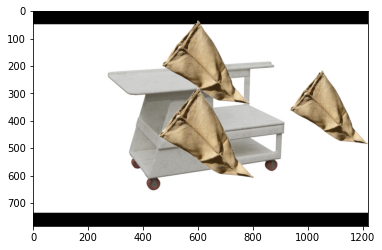

In [8]:
fig, ax = plt.subplots(1, 1)
ax.imshow(obj_fg_copy)

In [22]:
obj_fg_copy_2 = obj_fg_copy.copy()
obj_mask_copy_2 = obj_mask_copy.copy()

o_xmin, o_xmax, o_ymin, o_ymax = get_annotation_from_mask(obj_mask_copy_2)
obj_fg_copy_2 = obj_fg_copy_2.crop((o_xmin, o_ymin, o_xmax, o_ymax))
obj_mask_copy_2 = obj_mask_copy_2.crop((o_xmin, o_ymin, o_xmax, o_ymax))
orig_w, orig_h = obj_fg_copy_2.size


M = np.eye(3)
# x perspective (about y)
M[2, 0] = 0.0005
# y perspective (about x)
M[2, 1] = -0.0005
coords = np.array([[0, 0], [orig_w, 0], [0, orig_h], [orig_w, orig_h]])
max_w = 0
max_h = 0
for coord in coords:
    denom = M[2, 0] * coord[0] + M[2, 1] * coord[1] + M[2, 2]
    max_w = max(max_w, coord[0] / denom)
    max_h = max(max_h, coord[1] / denom)
max_w = int(max_w + 1)
max_h = int(max_h + 1)
print(max_w, max_h)
obj_fg_copy_2 = Image.fromarray(
    cv2.warpPerspective(
        pil_to_array_3c(obj_fg_copy_2), M, dsize=(max_w, max_h)
    )
)
obj_mask_copy_2 = Image.fromarray(
    cv2.warpPerspective(
        pil_to_array_1c(obj_mask_copy_2), M, dsize=(max_w, max_h)
    )
)
if max_h > orig_h or max_w > orig_w:
    obj_fg_copy_2 = obj_fg_copy_2.resize(
        (orig_w, orig_h), Image.ANTIALIAS
    )
    obj_mask_copy_2 = obj_mask_copy_2.resize(
        (orig_w, orig_h), Image.ANTIALIAS
    )

813 895


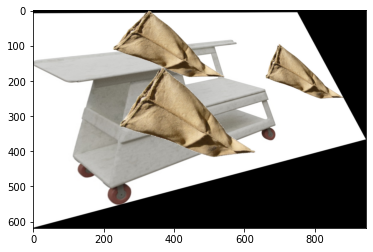

In [23]:
fig, ax = plt.subplots(1, 1)
ax.imshow(obj_fg_copy_2)

In [24]:
bg_copy = bg.copy()
bg_copy.paste(obj_fg_copy_2, (50, 50), obj_mask_copy_2)


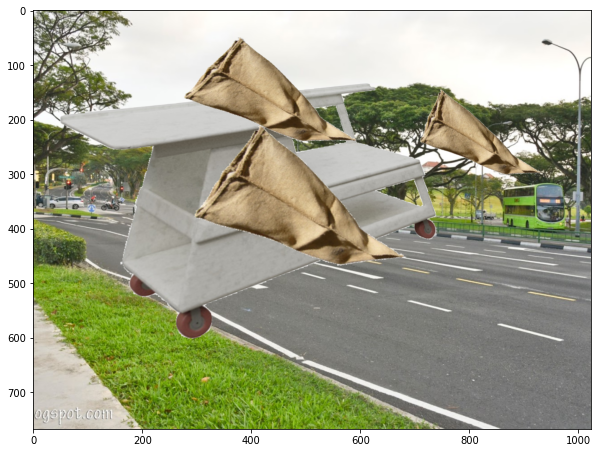

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(bg_copy)